## Autocorrect Feature, Vocabulary, Insights, Information Extraction 
**Project Scope: Now the dataset including 622 unique quantum articles**. 
<br>The articles published from *2003-09-15* to *2022-12-01* in https://newatlas.com/.
<br>**Creating Vocabulary to read and write the Quantum Physics articles** 
<br>**Autocorrector Feature Designing**
<br>**Information Extraction** (about *Spintronics*)

In [1]:
# importing libraries
import pandas as pd
import numpy as np

import re
import textdistance
from collections import Counter
import string

import spacy
nlp = spacy.load('en_core_web_lg')

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance

import networkx as nx
stop_words = list(stopwords.words('english'))

from string import punctuation
from heapq import nlargest

import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt

## Creating a Quantum Word List
Having a list of words which are appeared in a special subject (here the Quantum) is helpful in many porpuses, such as: reading, applying and comrehending the *special text*, *creating a special vocabulary* and  *Designing autocorrect feature* and etc.

In [2]:
df = pd.read_csv("Quantum_Articles_NewAtlas.csv")
df.head(2)

,Title,Author,Article,Published On,Link
0,IBM brings quantum computing to the masses,"['Jon Simon Feature Photo Service For Ibm', 'C...","For the first time, IBM Research has thrown op...",2016-05-06 07:11:29.000,https://newatlas.com/quantum-processor-qubits-...
1,Diamond-based quantum computer paired with sup...,"['Pawsey Supercomputing Research Centre', 'Mic...",Quantum computing may have just taken a major ...,2022-06-03 06:39:18.610,https://newatlas.com/computers/quantum-compute...


### Quantum Vocabulary

In [204]:
len(stop_words)

179

In [73]:
def common_function(text):
    text = text.lower()

    # Removing punctuations
    text = text.replace("’s", "")
    text = text.replace("n’t" , " ")
    text = text.replace("’d", "")
    text = text.replace("’ve", "")    
    #text = text.translate(str.maketrans('', '', string.punctuation))
    #text = re.sub(" \d+", " ", text)
    
    #Remving numbers
    #text = re.sub(r'[0-9]+', '', text)
    
    #Remving all characters but alphabets
    text=re.sub("[^A-Z a-z]", ' ', text)
    
    #Removing multiple spaces
    text = re.sub(' +', ' ', text)

    
    # Tokenizing
    Token_L= text.split()
    Token_L = [token.replace(" ","") for token in Token_L]
    
    # Removing stopwords
    Token_L = [token for token in Token_L if not token in stop_words]
    
    # Removing Charghters of formulas(such as c, v, q and etc.)
    Token_L = [token for token in Token_L if len(token)>2]
    
    # Lemmatization
    Token_L = [token.lemma_ for token in nlp(" ".join(Token_L))]    
    
    return(Token_L)

In [74]:
df["Article"][:200]

0      For the first time, IBM Research has thrown op...
1      Quantum computing may have just taken a major ...
2      March 31, 2008 Physicists at Padova University...
3      With the quantum computing race heating up bet...
4      March 3, 2008 An Australian project has develo...
                             ...                        
195    When trying to see objects that are too small ...
196    Researchers at Empa and EPFL have created one ...
197    Physicists in Germany have produced the coldes...
198    A team of German physicists has just created t...
199    Researchers from Australia's Swinburne Univers...
Name: Article, Length: 200, dtype: object

*To prevent following Error word_L list is separated in 3 parts then they will be unified*
ValueError: [E088] Text of length 2624523 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. 

In [75]:
text1 =" ".join(df["Article"][:200]) 
word_L1 = common_function(text1)

In [76]:
text2 =" ".join(df["Article"][200:400]) 
word_L2 = common_function(text2)

In [77]:
text3 =" ".join(df["Article"][400:500]) 
word_L3 = common_function(text3)

In [78]:
text4 =" ".join(df["Article"][500:600]) 
word_L4 = common_function(text4)

In [79]:
text5 =" ".join(df["Article"][600:]) 
word_L5 = common_function(text5)

In [80]:
word_L = word_L1 + word_L2 + word_L3 + word_L4 + word_L5
len(word_L)

341709

### WordCloud

In [82]:
def word_cloud(text):
    
    wordcloud = WordCloud(width=2400,height=1200, background_color = "white", max_words = 200).generate(text)
    # plot the wordcloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

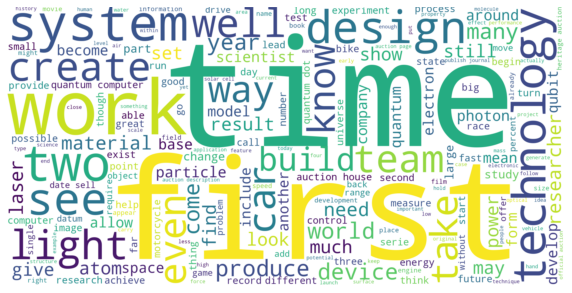

In [85]:
L = [w for w in word_L if len(w)>2]

more_stop_words = ["one", "use", "make", "new", "say"]
L = [w for w in word_L if not w in more_stop_words]

text = " ".join(L)

word_cloud(text)

### Quantum Vocabulary set

In [86]:
Q_vocab = set(word_L)
len(Q_vocab)

20508

In [207]:
print("Ignoring stopwords, roughly there are ({}) words in the text. including ({}) unique words.".format(len(word_L) ,  len(Q_vocab)))

Ignoring stopwords, roughly there are (341709) words in the text. including (20508) unique words.


### AutoCorrect Feature

To have AutoCorrector the probebility matters most, so creating a Collections Counter (word_frequancy) is necessary.
<br>Then the autocorector feature offer some nearest word to what is wrote by user, in realtime.

In [168]:
# Collectin Countor of Words
word_frequency = {}  
word_frequency = Counter(word_L)

print("Top 10 most common words:")
word_frequency.most_common()[0:10]

Top 10 most common words:


[('quantum', 3051),
 ('one', 2403),
 ('use', 2234),
 ('new', 1905),
 ('auction', 1809),
 ('time', 1687),
 ('make', 1653),
 ('first', 1555),
 ('year', 1358),
 ('could', 1293)]

In [169]:
word_frequency['would']

1024

In [170]:
# Collectin Countor of Propbabilities of Words (regarding theie frequencies)
probability = {}     
    
for w in word_frequency.keys():
    probability[w] = word_frequency[w]/sum(word_frequency.values())

In [171]:
# The probability of appearing top 10 words in articles
sort_probability = sorted(probability.items(), key=lambda x: x[1], reverse=True)
for i in sort_orders[:10]:
    print(i[0], round(i[1],3))

quantum 0.009
one 0.007
use 0.007
new 0.006
auction 0.005
time 0.005
make 0.005
first 0.005
year 0.004
could 0.004


In [194]:
def autocorrector(word):
    word = word.lower()
    if word in Q_vocab:
        return('Your word seems to be correct')
    else:
        sim = [1-(textdistance.Jaccard(qval=3).distance(w,word)) for w in word_frequency.keys()]
        df0 = pd.DataFrame.from_dict(probability, orient='index').reset_index()
        df0 = df0.rename(columns={'index':'Word', 0:'Similarity'})
        df0['Similarity'] = sim
        output = df0.sort_values('Similarity', ascending=False).head(10)
        return(output)

In [196]:
autocorrector("quantum")

'Your word seems to be correct'

In [199]:
autocorrector("quantom")

,Word,Similarity
5509,quantop,0.666667
10107,quant,0.600000
15780,quantu,0.500000
4003,quanta,0.500000
9,quantum,0.428571
7147,phantom,0.428571
20429,quan,0.400000
3607,quantity,0.375000
4530,quantify,0.375000
1238,quantize,0.375000


In [200]:
autocorrector("spin")

'Your word seems to be correct'

In [201]:
autocorrector("spintronic")

'Your word seems to be correct'

In [202]:
autocorrector("spintro_nic")

,Word,Similarity
2009,spintronic,0.545455
9407,intro,0.333333
415,introduce,0.230769
10095,pint,0.222222
546,spin,0.222222
11722,reintroduce,0.200000
3569,intra,0.200000
3999,introduction,0.187500
7127,intrude,0.166667
8659,spinoff,0.166667


**It's Continuing...